# Modeling

# Varun Mandalapu

Please go through "Data Exploration" notebook prior to this notebook as I implemented some insights from that.

Import required packages and modules for modeling, Needed libraries are Scikit-Learn, Pandas, Numpy, Seaborn & TQDM

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd, numpy as np, math
import seaborn as sns
import matplotlib as plt
from sklearn import linear_model, ensemble, tree
from sklearn.model_selection import GridSearchCV,KFold, train_test_split, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from tqdm import tqdm_notebook as tqdm

Import data for modeling

In [3]:
Model_Data = pd.read_csv('Modeling Test Data.csv')
Model_Data.head()

,y,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10
0,58.891377,5285.076955,8102.610429,-142802.4627,0.731818,61045.686450,183502.7911,2418498.392,27880.60083,360626.7592,4
1,57.641838,2094.137183,7432.119245,-147434.0657,2.527586,48485.220290,232809.7287,1779351.332,32153.75776,382670.3624,5
2,53.746536,5830.245294,6613.941822,-129496.5961,2.625691,36301.747910,214837.0432,2072100.771,30642.70182,370120.6062,2
3,36.168986,13039.246420,5270.829420,-439972.8126,0.844833,-5909.877785,173613.1204,1899841.158,41311.52728,329891.8986,4
4,32.669772,4611.755026,3456.822275,-138594.7123,4.058533,37602.705370,228498.4096,1925463.972,27522.27266,473752.7977,3


Dummy Code discrete variable var_10 as it is not evident that it is an ordinal column.

In [4]:
Model_Data = pd.get_dummies(Model_Data, columns = ['var_10'],prefix = 'var_10')
Model_Data.head()

,y,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10_1,var_10_2,var_10_3,var_10_4,var_10_5
0,58.891377,5285.076955,8102.610429,-142802.4627,0.731818,61045.686450,183502.7911,2418498.392,27880.60083,360626.7592,0,0,0,1,0
1,57.641838,2094.137183,7432.119245,-147434.0657,2.527586,48485.220290,232809.7287,1779351.332,32153.75776,382670.3624,0,0,0,0,1
2,53.746536,5830.245294,6613.941822,-129496.5961,2.625691,36301.747910,214837.0432,2072100.771,30642.70182,370120.6062,0,1,0,0,0
3,36.168986,13039.246420,5270.829420,-439972.8126,0.844833,-5909.877785,173613.1204,1899841.158,41311.52728,329891.8986,0,0,0,1,0
4,32.669772,4611.755026,3456.822275,-138594.7123,4.058533,37602.705370,228498.4096,1925463.972,27522.27266,473752.7977,0,0,1,0,0


Split data into Train & Test

In [5]:
# Separate Predictor variables and target variable
Model_Data_X = Model_Data.iloc[:,1:].copy()
Model_Data_Y = pd.DataFrame(Model_Data.iloc[:,0]).copy()

#Split Data into Train Test (90:10)
Model_Data_X_Train, Model_Data_X_Test, Model_Data_Y_Train, Model_Data_Y_Test = train_test_split(Model_Data_X,Model_Data_Y, test_size = 0.1, random_state = 20, shuffle = True)

# Baseline Model

In this work, I want to construct a baseline model with Linear Regression and without any feature selections or transformations.

In [6]:
LR_Baseline = linear_model.LinearRegression()
Baseline_Model_Scores = cross_validate(LR_Baseline, Model_Data_X_Train, Model_Data_Y_Train, cv=5, scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print('Baseline Model R2 = ', np.mean(Baseline_Model_Scores.get('test_r2')).round(decimals = 3))
#np.absolute(Baseline_Model_Scores.get('test_neg_mean_absolute_error'))

Baseline Model R2 =  0.797


# Feature Selection

Multicollinearity Check

In this step, I remove attributes that are highly collinear based on correlation map plotted for Train data. The threshold is a correlation value >0.8

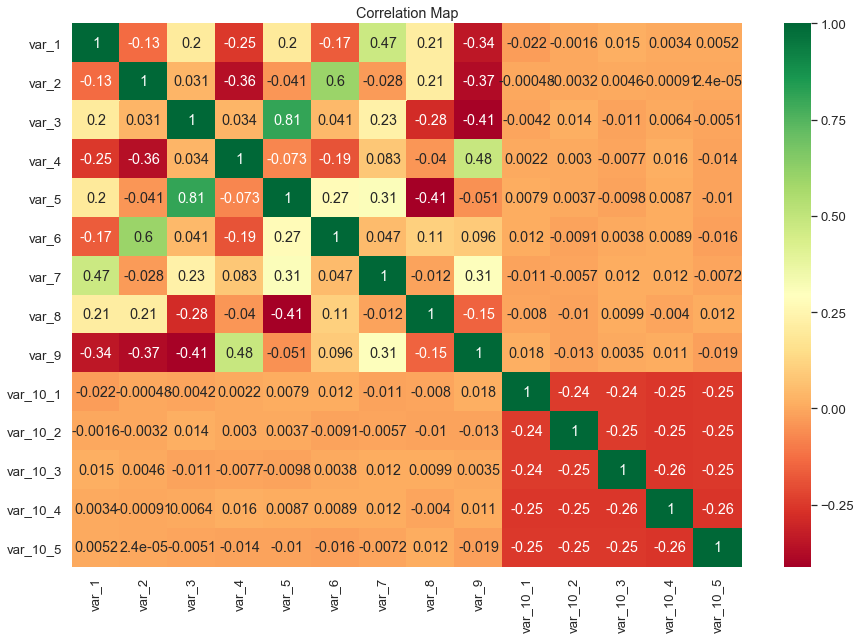

In [7]:
# Remove multicollinearity in data
fig = plt.figure(figsize=(15, 10))
fig.set_facecolor('white')
sns.set(font_scale=1.2)
Correlation_Map = sns.heatmap(Model_Data_X_Train.corr(), annot = True, cmap="RdYlGn").set_title("Correlation Map")

Based on correlation map we observe that 'var_3' and 'var_5' are correlated with 0.81. In order to remove multicollinearity, I am removing 'var_5'  from the data. I selected to remove 'var_5' as 'var_3' has more correlation 0.6 with target 'y' compared to '0.4' for 'var_5' (available in exploration notebook)

Generally, if the data descriptions are available, this decision to remove a column is made based on both correlation and the column representations.

In [8]:
Model_Data_X_Train.drop(['var_5'], axis = 1, inplace = True)
Model_Data_X_Test.drop(['var_5'], axis = 1, inplace = True)
Columns_Data_X = Model_Data_X_Train.columns
Model_Data_X_Train.head()

,var_1,var_2,var_3,var_4,var_6,var_7,var_8,var_9,var_10_1,var_10_2,var_10_3,var_10_4,var_10_5
6706,7340.853844,4962.682153,283333.0549,0.477940,148653.37080,1.114948e+06,19320.86016,93338.21245,0,0,0,0,1
3527,5997.192374,8612.915338,286818.1064,1.207340,178878.60640,1.675598e+06,13974.95185,75495.87872,0,0,0,0,1
1485,10952.439820,7793.290207,177182.5503,0.895527,159668.90880,3.115767e+06,22472.88792,128969.42060,0,1,0,0,0
974,7164.288177,7248.496947,209739.9293,0.824476,162912.93620,2.027060e+06,26437.35549,201248.59710,0,0,0,1,0
5450,11553.612690,-491.967384,-233317.7691,0.596240,-25360.93648,-8.793266e+04,16100.64161,132646.09190,1,0,0,0,0


Initialize Column Transformed to scale only continuous varriables in data

In [9]:
numerical_features = Model_Data_X_Train.dtypes == 'float'
transformer = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)], remainder='passthrough')

Embedded feature selection method based on random forest.

In [10]:
# Feature Selection based on Embedded Method (Random Forest)

Feature_Selection = SelectFromModel(ensemble.RandomForestRegressor(n_estimators = 100), threshold = 0.01)


# Hyperparameter Search Space Initialization

In [11]:
# Defining Hyperparameter Search Space for optimal parameters for Linear Regression

LR = linear_model.LinearRegression()
hyperparameters_LR = {"normalize": [True,False]}
Grid_Search_LR = GridSearchCV(LR, param_grid = hyperparameters_LR, cv=5, verbose=0, n_jobs=-1)

# Defining Hyperparameter Search Space for optimal parameters for Elastic Net

EN = linear_model.ElasticNetCV()
hyperparameters_EN = {"l1_ratio": [0.0001,0.001,0.1,0.3,0.5,0.7,0.9,1],"n_alphas" : [100, 200, 500] }
Grid_Search_EN = GridSearchCV(EN, param_grid = hyperparameters_EN, cv=5, verbose=0, n_jobs=-1)

# Defining Hyperparameter Search Space for optimal parameters for Decision Tree Regressor

DT = tree.DecisionTreeRegressor()
hyperparameters_DT = {"criterion": ["mse", "friedman_mse", "mae"], "max_depth": [3,10,20,40,60,80,100],"min_impurity_decrease": [0.001,0.01,0.1]}
Grid_Search_DT = GridSearchCV(DT, param_grid = hyperparameters_DT, cv=5, verbose=0, n_jobs=-1)

# Defining Hyperparameter Search Space for optimal parameters for Gradient Boosting Regressor

GBR = ensemble.GradientBoostingRegressor()
hyperparameters_GBR = {"loss": ["ls", "lad", "huber"] ,"learning_rate" : [0.0001, 0.001, 0.01, 0.1], "n_estimators" :[10,100, 500,1000] }
Grid_Search_GBR = GridSearchCV(GBR, param_grid = hyperparameters_GBR, cv=5, verbose=0, n_jobs=-1)

# Defining Hyperparameter Search Space for optimal parameters for Random Forest Regressor

RF = ensemble.RandomForestRegressor()
hyperparameters_RF = {"n_estimators": [10, 100, 500] ,"max_features" : ["auto","sqrt","log2"], "n_jobs": [-1]}
Grid_Search_RF = GridSearchCV(RF, param_grid = hyperparameters_RF, cv=5, verbose=0, n_jobs=-1)


# Model Pipelines Initialization

In [12]:
# Creating Pipelines for each model.
Pipelines = []
LR_Pipeline = Pipeline([('Scale_Float', transformer),('LR_feature_selection', Feature_Selection),('LR_Regression',Grid_Search_LR)])
Pipelines.append(('Linear_Reg',LR_Pipeline))
EN_Pipeline = Pipeline([('Scale_Float', transformer),('EN_feature_selection', Feature_Selection),('EN_Regression',Grid_Search_EN)])
Pipelines.append(('Elastic_Net',EN_Pipeline))
DT_Pipeline = Pipeline([('Scale_Float', transformer),('DT_feature_selection', Feature_Selection),('DT_Regression',Grid_Search_DT)])
Pipelines.append(('Descision_Tree',DT_Pipeline))
GBR_Pipeline = Pipeline([('Scale_Float', transformer),('GBR_feature_selection', Feature_Selection),('GBR_Regression',Grid_Search_GBR)])
Pipelines.append(('Gradient_Boost_Reg', GBR_Pipeline))
RF_Pipeline = Pipeline([('Scale_Float', transformer),('RF_feature_selection', Feature_Selection),('RF_Regression',Grid_Search_RF)])
Pipelines.append(('Random_Forest',RF_Pipeline))


# Cross Validation on 90% data

Models are cross validated on 90% data to select the best algorithm for current dataset based on the performance metrics

In [13]:
warnings.filterwarnings('ignore')
# Setting the number of splits needed in k fold
K_fold = KFold(n_splits=5, random_state = 10, shuffle = True)

# Initializing empty lists to track model performances
Cross_Validation_Results_R2 = []; Cross_Validation_Results_RMSE = []; Model_Name = []; R2_Output = []
RMSE_Output = [];MAE_Output = []; R2_Uncertainty = []; MAE_Uncertainty = []

#Looping all models that need to be evaluated.
for model, pipeline in tqdm(Pipelines, desc = "Models Progress"):
    
    #Initialize empty lists for storing each fold performance of cross validation
    Cross_Validation_Results_R2 = []
    Cross_Validation_Results_RMSE = []
    Cross_Validation_Results_MAE = []
    
    # Cross Validation
    for train, test in K_fold.split(Model_Data_X_Train,Model_Data_Y_Train):
        # Fold Count
        Trained_Model = ()
        # Data and labels extraction for Training and testing in current fold of Cross Validation
        train_data = Model_Data_X_Train[Model_Data_X_Train.index.isin(train)]
        train_label = Model_Data_Y_Train[Model_Data_Y_Train.index.isin(train)]
        test_data = Model_Data_X_Train[Model_Data_X_Train.index.isin(test)]
        test_label = Model_Data_Y_Train[Model_Data_Y_Train.index.isin(test)]
        Trained_Model = pipeline.fit(train_data,train_label)
        Test_predictions = Trained_Model.predict(test_data)
        
        # Performance metrics evaluated in this study
        R2_Score = r2_score(test_label, Test_predictions, sample_weight=None, multioutput='uniform_average')
        RMSE_Score = math.sqrt(mean_squared_error(test_label, Test_predictions, sample_weight=None, multioutput='uniform_average'))
        MAE_Score = mean_absolute_error(test_label, Test_predictions,)
        
        # Appending individual fold performance score to empty list
        Cross_Validation_Results_R2.append(R2_Score)
        Cross_Validation_Results_RMSE.append(RMSE_Score)
        Cross_Validation_Results_MAE.append(MAE_Score)
        

    
    # Calculate the final cross validation performance by averaging each fold performance and append it to an empty list for final comparison of models.       
    R2_Output.append(np.mean(Cross_Validation_Results_R2).round(3))
    RMSE_Output.append(np.mean(Cross_Validation_Results_RMSE).round(3))
    MAE_Output.append(np.mean(Cross_Validation_Results_MAE).round(3))
    R2_Uncertainty.append(np.std(Cross_Validation_Results_R2).round(3))
    MAE_Uncertainty.append(np.std(Cross_Validation_Results_MAE).round(3))
    Model_Name.append(model)

In [14]:
# Setting all measures in a single data frame for comparing different models to choose best model for this study based on selected dataset.

Model_Performances = pd.concat([pd.DataFrame(Model_Name).reset_index(drop=True), pd.DataFrame(MAE_Output).reset_index(drop=True),
                                pd.DataFrame(MAE_Uncertainty).reset_index(drop=True), pd.DataFrame(R2_Output).reset_index(drop=True),
                                pd.DataFrame(R2_Uncertainty).reset_index(drop=True), pd.DataFrame(RMSE_Output).reset_index(drop=True)], axis = 1)
Model_Performances = Model_Performances.set_axis(['Model_Name','MAE_Value','MAE_Uncertainty', 'Model_R2_Value','R2_Uncertainty','Model_RMSE'], axis = 1, inplace = False)
Model_Performances

,Model_Name,MAE_Value,MAE_Uncertainty,Model_R2_Value,R2_Uncertainty,Model_RMSE
0,Linear_Reg,5.412,0.118,0.778,0.012,7.078
1,Elastic_Net,5.413,0.118,0.778,0.012,7.078
2,Descision_Tree,1.851,0.028,0.972,0.001,2.514
3,Gradient_Boost_Reg,1.206,0.022,0.989,0.001,1.546
4,Random_Forest,1.336,0.018,0.986,0.001,1.790


# Train Best Model & Test on Hold Out

The final model is selected based on the best R Squared and low MAE observed in above 90% train data cross validation.

Based on this criteria, I selected Gradient Boosted Regressor. Once GBR is selected, the whole 90% train data goes through the pipeline (scaling, feature selection & parameter search) and then the trained model is tested on 10% hold out data.

In [15]:
# Selecting Best Model based on low root mean square error and R2 closer to one, Gradient Boosting Regressor does better compared to all other models in on this selected dataset

# Training best model on whole dataset (Without the four players) and testing the trained model on four players.
Best_Model_Training = GBR_Pipeline.fit(Model_Data_X_Train,Model_Data_Y_Train)
Best_Model_Predictions = Best_Model_Training.predict(Model_Data_X_Test)

#Performance metrics for 10% holdout data
R2_Test_Output = r2_score(Model_Data_Y_Test,Best_Model_Predictions).round(3)
MAE_Test_Output = mean_absolute_error(Model_Data_Y_Test,Best_Model_Predictions).round(3)
print('Test data MAE & R2', MAE_Test_Output,R2_Test_Output)

Test data MAE & R2 1.186 0.991


# Feature Importances for Final Model

A final model is created by fitting GBR training pipeline on whole data. This can be treated as a production model. The feature importances for this model are extracted for analysis.

In [16]:
Final_Model = GBR_Pipeline.fit(Model_Data_X.loc[:, Model_Data_X.columns != 'var_5'],Model_Data_Y)
# Extract Boolean feature names selected in feature selection
features = pd.DataFrame(Final_Model.named_steps['GBR_feature_selection'].get_support(), index = Columns_Data_X, columns = ['Selected_Column'])
# Column names extraction for selected features in feature selection part of pipeline
Selected_Features = features.loc[features['Selected_Column'] == True]
# Feature importances
Feature_Importances = pd.DataFrame(Final_Model.named_steps["GBR_Regression"].best_estimator_.feature_importances_, index = Selected_Features.index, columns = ['Importance']).round(3)
Feature_Importances

,Importance
var_2,0.399
var_3,0.382
var_9,0.200
var_10_4,0.020
